# Visualisations

## Imports

In [ ]:
#| output: false
import string
from os.path import join
import glob
import json

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.lines import Line2D
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import kendalltau, ttest_1samp


import torch
from thingsvision import get_extractor, get_extractor_from_model
from tqdm import tqdm

from harmonization.models import (
    load_ViT_B16,
    load_ResNet50,
    load_VGG16,
    load_EfficientNetB0,
    load_tiny_ConvNeXT,
    load_tiny_MaxViT,
    load_LeViT_small,
)


from NaturalCogSci.helpers import get_project_root

%config InlineBackend.figure_format='retina'

## Plotting Parameters

In [ ]:

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

FIGWIDTH = 6.99866
CATEGORYTRIALS = 120
REWARDTRIALS = 60

project_root = get_project_root()
with open(join(project_root, "data", "model_plot_params.json")) as f:
    plot_params = json.load(f)
plot_params = {k.replace("/","_"):v for k,v in plot_params.items()}


cmap = ["#7570B3","#D95F02","#A6761D","#1B9E77","#972D15","#E6AB02","#666666"]
sns.set_palette(cmap)
sns.color_palette(cmap)



SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


latex_context = {
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
}


# retina figures
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300




## Main Figures

### Category Learning

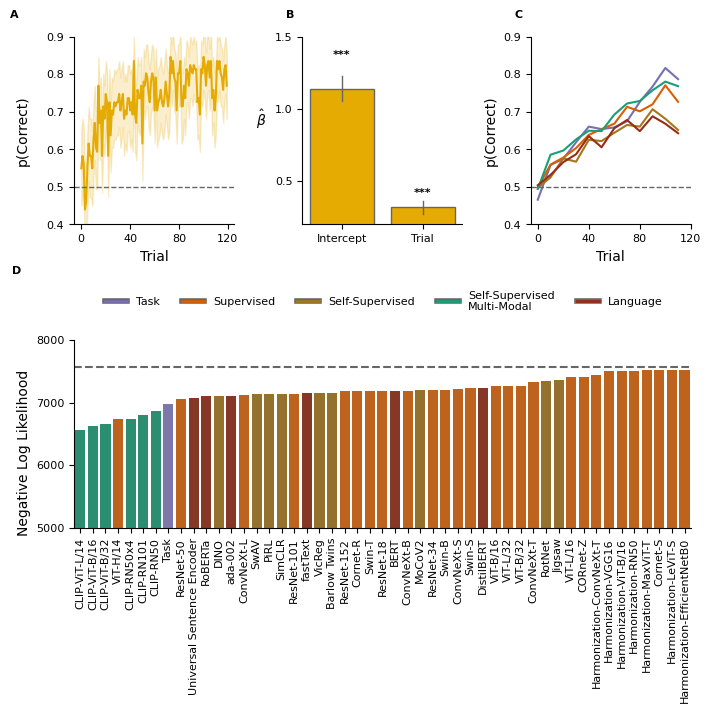

In [ ]:
fig = plt.figure(layout="constrained",figsize=(FIGWIDTH, FIGWIDTH))

spec = fig.add_gridspec(2, 3)
ax00 = fig.add_subplot(spec[0, 0])
ax00.text(-0.4, 1.1, string.ascii_uppercase[0], transform=ax00.transAxes, weight='bold')



behavioural_df = pd.read_csv(join(project_root, "data", "human_behavioural", "category_learning", "above_chance.csv"))
sns.lineplot(data=behavioural_df,x="trial",y="correct",ax=ax00,color=cmap[-2])
ax00.set_xlabel("Trial")
ax00.set_ylabel("p(Correct)")
ax00.set_ylim(.4,.9)
ax00.axhline(.5,ls="--",color=cmap[-1],lw=1)
ax00.set_xticks([0,40,80,120])
# make x ticks 1 indexed


ax01 = fig.add_subplot(spec[0, 1])
ax01.text(-0.1, 1.1, string.ascii_uppercase[1], transform=ax01.transAxes, weight='bold')

glmm_df = pd.read_csv(join(project_root, "data", "human_behavioural", "category_learning", "glmm.csv"))
glmm_df = glmm_df.replace(['(Intercept)', 'trial'], ["Intercept", "Trial"])
ax01.bar(glmm_df['term'],glmm_df['estimate'],color=cmap[-2],edgecolor=cmap[-1],lw=1,width=0.8)
ax01.set_ylabel(r'$\hat{\beta}$',rotation=0,labelpad=10)
ax01.set_ylim(ymin=0.2,ymax=1.4)
ax01.set_yticks([0.5,1.0,1.5])

for regressor in glmm_df['term'].values:

    ax01.plot([regressor,regressor],
    [float(glmm_df[glmm_df['term']==regressor]['estimate'] + glmm_df[glmm_df['term']==regressor]['std.error']),
    float(glmm_df[glmm_df['term']==regressor]['estimate'] - glmm_df[glmm_df['term']==regressor]['std.error'])],
    color=cmap[-1],lw=1)

    

ax01.annotate('***',xy=('Intercept', 1.35), weight='bold',ha='center')
ax01.annotate('***', xy=('Trial', .4), weight='bold',ha='center')

ax02 = fig.add_subplot(spec[0, 2])
ax02.text(-0.1, 1.1, string.ascii_uppercase[2], transform=ax02.transAxes, weight='bold')

best_models = [
    join(project_root, "data", "learner_behavioural", "category_learning", "clip_ViT-L_14_l2_original.csv"),
    join(project_root, "data", "learner_behavioural", "category_learning", "vit_h_14_l2_original.csv"),
    join(project_root, "data", "learner_behavioural", "category_learning", "task_l2_original.csv"),
    join(project_root, "data", "learner_behavioural", "category_learning", "universal_sentence_encoder_l2_original.csv"),
    join(project_root, "data", "learner_behavioural", "category_learning", "dino-rn50_l2_original.csv"),


]

best_models = [pd.read_csv(x) for x in best_models]
best_models = pd.concat(best_models)
best_models["model_correct"] = np.where(best_models.true_category_binary == 1, best_models.prob, 1-best_models.prob)
best_models["model_correct"] = np.where(best_models.model_correct >= .5, 1, 0)
best_models["colour"] = best_models["features"].apply(lambda x: plot_params[x]["colour"])
best_models["features"] = best_models["features"].apply(lambda x: plot_params[x]["name"])
best_models = best_models.reset_index(drop=True)

# average correct every 5 trials
best_models['model_correct'] = best_models.groupby(best_models.index // 10)['model_correct'].transform('mean')
# take every 5th trial
best_models = best_models.iloc[::10, :]

sns.lineplot(data=best_models,x="trial",y="model_correct",hue="colour",
             ax=ax02,palette=cmap[:-2],errorbar=None,legend=False,
             hue_order=["task","supervised","self-supervised","self-supervised multimodal","text"])

ax02.set_xlabel("Trial")
ax02.set_ylabel("p(Correct)")
ax02.set_ylim(.4,.9)
ax02.axhline(.5,ls="--",color=cmap[-1],lw=1)
ax02.set_xticks([0,40,80,120])


ax1 = fig.add_subplot(spec[1, :])
dfs = glob.glob(join(project_root, "data", "learner_behavioural", "category_learning", "*_l2_original.csv"))
dfs = [pd.read_csv(x) for x in dfs]
model_df = pd.concat(dfs)
model_df["nll"] = - np.where(model_df.choice == 1, np.log(model_df.prob), np.log(1-model_df.prob))
chance_level = - model_df.participant.nunique() * CATEGORYTRIALS * np.log(0.5)
model_df = model_df.groupby("features").agg({"nll":"sum"}).reset_index()
model_df = model_df.sort_values(by="nll",ascending=True).reset_index(drop=True)
model_df["color"] = model_df["features"].apply(lambda x: plot_params[x]["colour"])
model_df["features"] = model_df["features"].apply(lambda x: plot_params[x]["name"])
category_model_df = model_df

sns.barplot(
    data=model_df,x="features",y="nll",hue="color",dodge=False,ax=ax1,
    hue_order=["task","supervised","self-supervised","self-supervised multimodal","text"]
            )
ax1.legend_.remove()
ax1.axhline(chance_level,ls="--",color=cmap[-1])
# show x-axis ticks in the bars
ax1.xaxis.set_tick_params(rotation=90)
ax1.set_ylabel("Negative Log Likelihood")
ax1.set_xlabel("")
ax1.set_ylim(5000,8000)
ax1.set_yticks([5000,6000,7000,8000])
ax1.yaxis.set_label_coords(-0.07,.4)
ax1.text(-0.1, 1.35, string.ascii_uppercase[3], transform=ax1.transAxes, weight='bold')
custom_legend_lines = [Line2D([0], [0], color=x, lw=2, path_effects=[pe.Stroke(linewidth=4, foreground=cmap[-1]), pe.Normal()]) for x in cmap[:-1]]
hue_order = ['Task','Supervised','Self-Supervised','Self-Supervised\nMulti-Modal','Language']
fig.legend(custom_legend_lines, hue_order, loc='center',bbox_to_anchor=(0.54, .58),ncol=5,frameon=False)
fig.align_ylabels([ax00,ax01,ax02,ax1])
plt.show()

with mpl.rc_context(latex_context):
    fig.savefig(join(project_root, "figures","category_learning.pdf"), bbox_inches='tight')

### Reward Learning

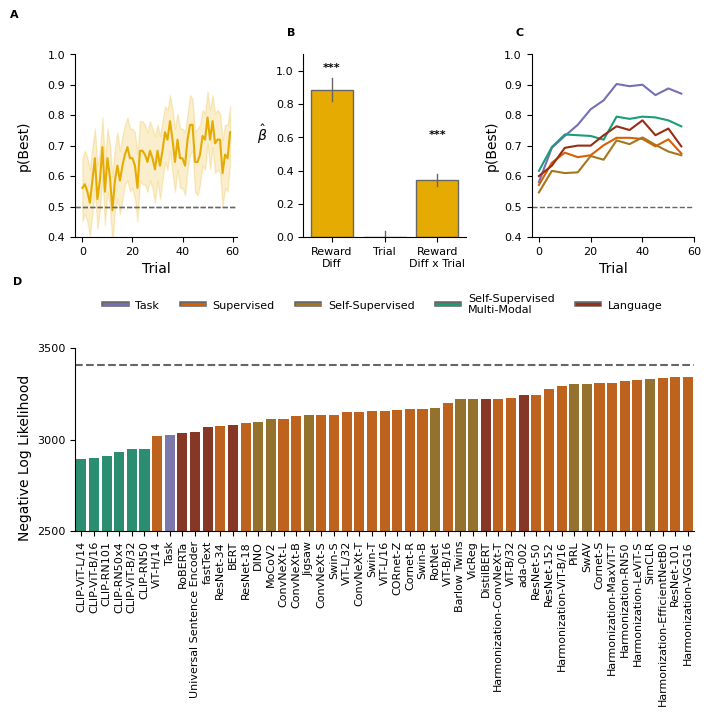

In [ ]:
fig = plt.figure(layout="constrained",figsize=(FIGWIDTH, FIGWIDTH))
spec = fig.add_gridspec(2, 3)
ax00 = fig.add_subplot(spec[0, 0])
ax00.text(-0.4, 1.2, string.ascii_uppercase[0], transform=ax00.transAxes, weight='bold')



ax00.set_xlabel("Trial")
ax00.set_ylabel("p(Correct)")
ax00.set_ylim(.4,.9)
ax00.axhline(.5,ls="--",color=cmap[-1],lw=1)
behavioural_df = pd.read_csv(join(project_root, "data", "human_behavioural", "reward_learning", "above_chance.csv"))
sns.lineplot(data=behavioural_df,x="trial",y="correct",ax=ax00,color=cmap[-2])
ax00.set_xlabel("Trial")
ax00.set_ylabel("p(Best)")
ax00.set_ylim(.4,1)
ax00.axhline(.5,ls="--",color=cmap[-1],lw=1)


ax01 = fig.add_subplot(spec[0, 1])
ax01.text(-0.1, 1.1, string.ascii_uppercase[1], transform=ax01.transAxes, weight='bold')



glmm_df = pd.read_csv(join(project_root, "data", "human_behavioural", "reward_learning", "glmm.csv"))
glmm_df = glmm_df.replace(['trial', 'rl_diff',"trial:rl_diff"], ["Trial", "Reward\nDiff","Reward\nDiff x Trial"])
glmm_df = glmm_df.reindex([1,0,2])
ax01.bar(glmm_df['term'],glmm_df['estimate'],color=cmap[-2],edgecolor=cmap[-1],lw=1)
ax01.set_ylabel(r'$\hat{\beta}$',rotation=0,labelpad=10)
ax01.set_ylim(ymin=0,ymax=1.1)
ax01.annotate('***',xy=('Reward\nDiff', 1.), weight='bold',ha='center')
ax01.annotate('***', xy=('Reward\nDiff x Trial', .6), weight='bold',ha='center')


for regressor in glmm_df['term'].values:

    ax01.plot([regressor,regressor],
    [float(glmm_df[glmm_df['term']==regressor]['estimate'] + glmm_df[glmm_df['term']==regressor]['std.error']),
    float(glmm_df[glmm_df['term']==regressor]['estimate'] - glmm_df[glmm_df['term']==regressor]['std.error'])],
    color=cmap[-1],lw=1)

ax02 = fig.add_subplot(spec[0, 2])
ax02.text(-0.1, 1.1, string.ascii_uppercase[2], transform=ax02.transAxes, weight='bold')

best_models = [
    join(project_root, "data", "learner_behavioural", "reward_learning", "clip_ViT-L_14_l2_original.csv"),
    join(project_root, "data", "learner_behavioural", "reward_learning", "vit_h_14_l2_original.csv"),
    join(project_root, "data", "learner_behavioural", "reward_learning", "task_l2_original.csv"),
    join(project_root, "data", "learner_behavioural", "reward_learning", "roberta_l2_original.csv"),
    join(project_root, "data", "learner_behavioural", "reward_learning", "resnet34_l2_original.csv"),
    join(project_root, "data", "learner_behavioural", "reward_learning", "dino-rn50_l2_original.csv"),


]

best_models = [pd.read_csv(x) for x in best_models]
best_models = pd.concat(best_models)
best_models["true_category_binary"] = np.where(best_models.right_reward >= best_models.left_reward, 1, 0)
best_models["model_correct"] = np.where(best_models.true_category_binary == 1, best_models.prob, 1-best_models.prob)
best_models["model_correct"] = np.where(best_models.model_correct >= .5, 1, 0)
best_models["colour"] = best_models["features"].apply(lambda x: plot_params[x]["colour"])
best_models["features"] = best_models["features"].apply(lambda x: plot_params[x]["name"])
best_models = best_models.reset_index(drop=True)
# average correct every 5 trials after the first trial


best_models['model_correct'] = best_models.groupby(best_models.index // 5)['model_correct'].transform('mean')
# take every 5th trial
best_models = best_models.iloc[::5, :]

sns.lineplot(data=best_models,x="trial",y="model_correct",hue="colour",
             ax=ax02,palette=cmap[:-2],errorbar=None,legend=False,
             hue_order=["task","supervised","self-supervised","self-supervised multimodal","text"])

ax02.set_xlabel("Trial")
ax02.set_ylabel("p(Best)")
ax02.set_ylim(.4,1)
ax02.axhline(.5,ls="--",color=cmap[-1],lw=1)
ax02.set_xticks([0,20,40,60])

ax1 = fig.add_subplot(spec[1, :])

dfs = glob.glob(join(project_root, "data", "learner_behavioural", "reward_learning", "*_l2_original.csv"))
dfs = [pd.read_csv(x) for x in dfs]
model_df = pd.concat(dfs)
model_df["prob"] = np.where(model_df.prob ==1,.99999,model_df.prob)
model_df["nll"] = - np.where(model_df.choice == 1, np.log(model_df.prob), np.log(1-model_df.prob))
chance_level = - model_df.participant.nunique() * REWARDTRIALS * np.log(0.5)
model_df = model_df.groupby("features").agg({"nll":"sum"}).reset_index()
model_df = model_df.sort_values(by="nll",ascending=True).reset_index(drop=True)
model_df["color"] = model_df["features"].apply(lambda x: plot_params[x]["colour"])
model_df["features"] = model_df["features"].apply(lambda x: plot_params[x]["name"])
reward_model_df = model_df

sns.barplot(
    data=model_df,x="features",y="nll",hue="color",dodge=False,ax=ax1,
    hue_order=["task","supervised","self-supervised","self-supervised multimodal","text"]
            )
ax1.legend_.remove()
ax1.axhline(chance_level,ls="--",color=cmap[-1])
# show x-axis ticks in the bars
ax1.xaxis.set_tick_params(rotation=90)
ax1.set_ylabel("Negative Log Likelihood")
ax1.set_xlabel("")
ax1.set_ylim(2500,3500)
ax1.set_yticks([2500,3000,3500])
ax1.yaxis.set_label_coords(-0.07,.4)
ax1.text(-0.1, 1.35, string.ascii_uppercase[3], transform=ax1.transAxes, weight='bold')
custom_legend_lines = [Line2D([0], [0], color=x, lw=2, path_effects=[pe.Stroke(linewidth=4, foreground=cmap[-1]), pe.Normal()]) for x in cmap[:-1]]
hue_order = ['Task','Supervised','Self-Supervised','Self-Supervised\nMulti-Modal','Language']
fig.legend(custom_legend_lines, hue_order, loc='center',bbox_to_anchor=(0.54, .58),ncol=5,frameon=False)
fig.align_ylabels([ax00,ax01,ax02,ax1])
plt.show()
with mpl.rc_context(latex_context):
    fig.savefig(join(project_root, "figures","reward_learning.pdf"), bbox_inches='tight')


### RSA

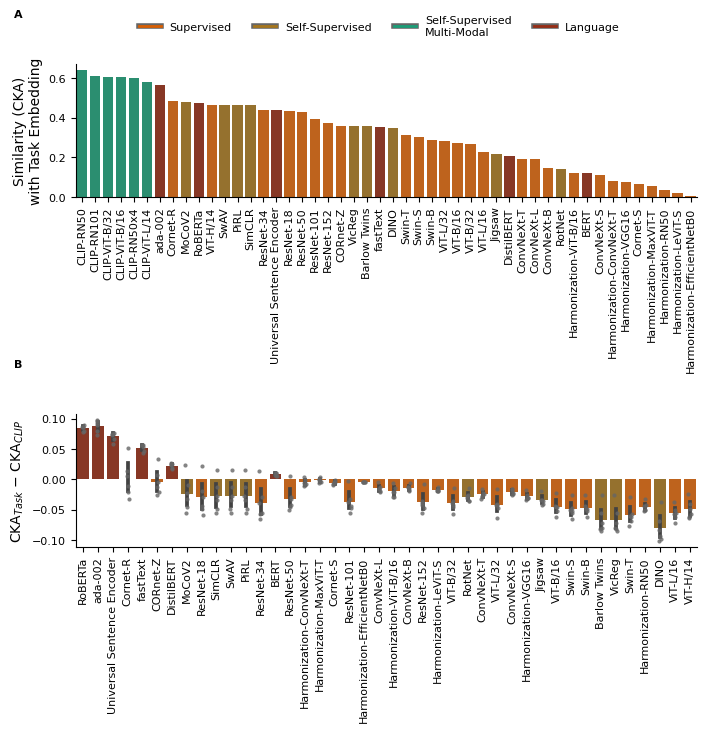

In [ ]:
fig = plt.figure(layout="constrained",figsize=(FIGWIDTH, FIGWIDTH))
spec = fig.add_gridspec(2,1)
ax00 = fig.add_subplot(spec[0, :])

task_cka_df = pd.read_csv(join(project_root,"data","cka","baseline.csv"))
task_cka_df = task_cka_df[task_cka_df.feature != "cornet-rt"].reset_index(drop=True)
task_cka_df = task_cka_df[task_cka_df.feature != "task"].reset_index(drop=True)
task_cka_df["colour"] = task_cka_df["feature"].apply(lambda x: plot_params[x]["colour"])

task_cka_df["features"] = task_cka_df["feature"].apply(lambda x: plot_params[x]["name"])
# sort
task_cka_df =task_cka_df.sort_values(by="cka",ascending=False).reset_index(drop=True)



sns.barplot(data=task_cka_df,x="features",y="cka",hue="colour",ax=ax00,dodge=False,
    hue_order=["task","supervised","self-supervised","self-supervised multimodal","text"])

ax00.legend_.remove()
ax00.set_ylabel("Similarity (CKA)\nwith Task Embedding")     
ax00.xaxis.set_tick_params(rotation=90)
ax00.set_xlabel("")
ax00.text(-0.1, 1.35, string.ascii_uppercase[0], transform=ax00.transAxes, weight='bold')
custom_legend_lines = [Line2D([0], [0], color=x, lw=2, path_effects=[pe.Stroke(linewidth=4, foreground=cmap[-1]), pe.Normal()]) for x in cmap[1:-1]]
hue_order = ['Supervised','Self-Supervised','Self-Supervised\nMulti-Modal','Language']
fig.legend(custom_legend_lines, hue_order, loc='center',bbox_to_anchor=(0.54, 1),ncol=5,frameon=False)

ax10 = fig.add_subplot(spec[1,:])
clip_cka_dfs = glob.glob(join(project_root,"data","cka","*clip*.csv"))

diff_dfs = []

task_cka_df = task_cka_df[task_cka_df.feature != "cornet-rt"].reset_index(drop=True)
task_cka_df = task_cka_df[task_cka_df.feature != "task"].reset_index(drop=True)
task_cka_df = task_cka_df[~task_cka_df.feature.str.startswith("clip")].reset_index(drop=True)
for i,df_path in enumerate(clip_cka_dfs):
    df = pd.read_csv(df_path)
    df = df[df.feature != "cornet-rt"].reset_index(drop=True)
    df = df[df.feature != "task"].reset_index(drop=True)
    df = df[~df.feature.str.startswith("clip")].reset_index(drop=True)
    df["colour"] = df["feature"].apply(lambda x: plot_params[x]["colour"])
    df["features"] = df["feature"].apply(lambda x: plot_params[x]["name"])

    diff_df = pd.merge(task_cka_df,df,on=["feature","colour"],how="outer")
    diff_df["diff"] = diff_df["cka_x"] - diff_df["cka_y"]
    diff_df = diff_df.sort_values(by="diff",ascending=False).reset_index(drop=True)
    diff_dfs.append(diff_df)

diff_df = pd.concat(diff_dfs)
new_sort = diff_df.groupby("feature")['diff'].mean().sort_values(ascending=False)

sorterIndex = dict(zip(new_sort, range(len(new_sort))))

diff_df['feature_rank'] = diff_df['features_x'].map(sorterIndex)
diff_df["features"] = diff_df["feature"].apply(lambda x: plot_params[x]["name"])

sns.barplot(data=diff_df,x="features",y="diff",hue="colour",ax=ax10,dodge=False,
    hue_order=["task","supervised","self-supervised","self-supervised multimodal","text"])

sns.stripplot(
    data=diff_df,
    x='features',
    y='diff',
    dodge=True,
    color=cmap[-1],
    alpha=.8,
    s=3,
    hue_order=["task","supervised","self-supervised","self-supervised multimodal","text"],
    ax=ax10)

ax10.legend_.remove()
ax10.set_ylabel("CKA${_{Task}}$ $-$ CKA${_{CLIP}}$")     
ax10.xaxis.set_tick_params(rotation=90)
ax10.set_xlabel("")
ax10.text(-0.1, 1.35, string.ascii_uppercase[1], transform=ax10.transAxes, weight='bold')



plt.show()
with mpl.rc_context(latex_context):
    fig.savefig(join(project_root, "figures","representations.pdf"), bbox_inches='tight')

## Supplementary Figures

### p Values For Trials

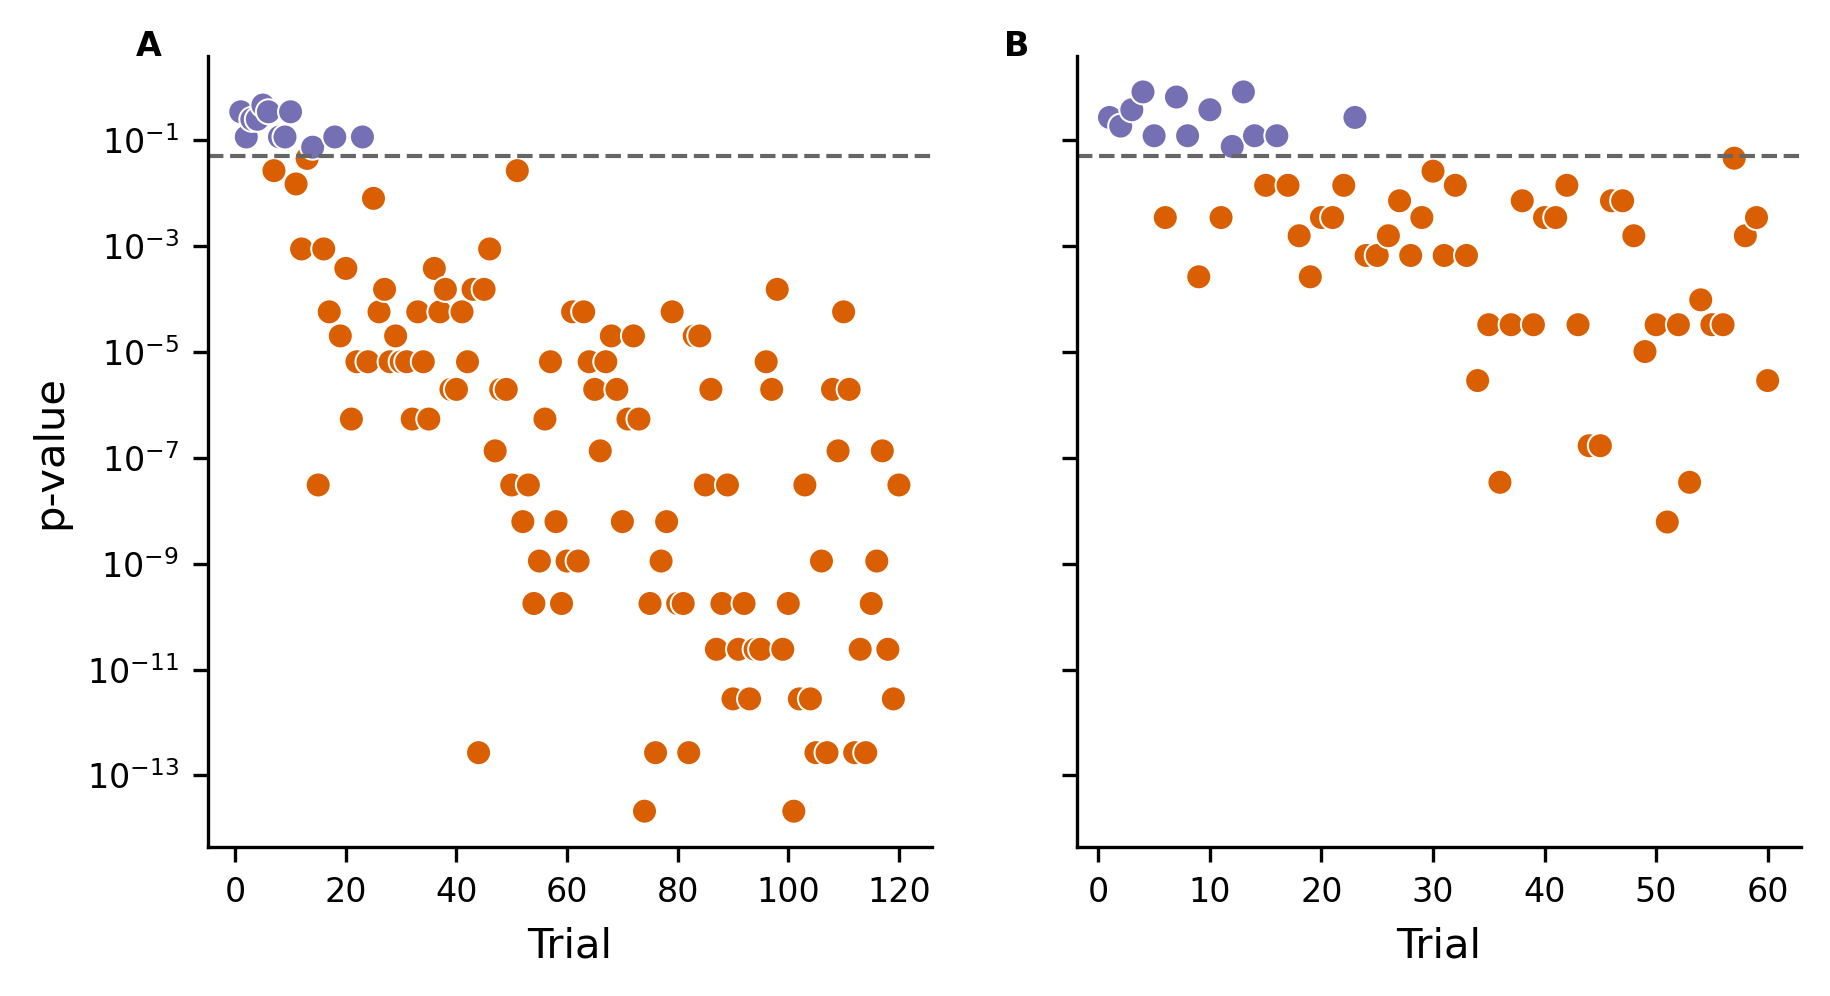

In [ ]:
SINGLECOLWIDTH = 3.4252
fig, ax = plt.subplots(1,2,figsize=(2*SINGLECOLWIDTH, SINGLECOLWIDTH),sharey=True)
behavioural_df = pd.read_csv(join(project_root, "data", "human_behavioural", "category_learning", "above_chance.csv"))

# loop through each trial in the behavioural df, and do a t-test against .5
# record p-values
p_values = []
for trial in behavioural_df.trial.unique():
    p_values.append(ttest_1samp(behavioural_df[behavioural_df.trial == trial].correct, .5)[1])

category_p_df = pd.DataFrame({"trial":np.array(behavioural_df.trial.unique())+1,"p":p_values})
category_p_df["sig"] = np.where(category_p_df.p < .05, 1, 0)

sns.scatterplot(data=category_p_df,x="trial",y="p",hue='sig',ax=ax[0],color=cmap[-2])
# log scale for y axis
ax[0].set_yscale('log')
ax[0].set_xlabel("Trial")
ax[0].set_ylabel("p-value")
# dashed grey horizontal line at .05
ax[0].axhline(.05,ls="--",color=cmap[-1],lw=1)
# remove legend
ax[0].legend_.remove()

# do the same for reward learning
behavioural_df = pd.read_csv(join(project_root, "data", "human_behavioural", "reward_learning", "above_chance.csv"))
p_values = []
for trial in behavioural_df.trial.unique():
    p_values.append(ttest_1samp(behavioural_df[behavioural_df.trial == trial].correct, .5)[1])

reward_p_df = pd.DataFrame({"trial":np.array(behavioural_df.trial.unique())+1,"p":p_values})
reward_p_df["sig"] = np.where(reward_p_df.p < .05, 1, 0)

sns.scatterplot(data=reward_p_df,x="trial",y="p",hue='sig',ax=ax[1],color=cmap[-2])
# log scale for y axis
# match it to the category learning plot
ax[1].set_yscale('log')




ax[1].set_xlabel("Trial")
ax[1].set_ylabel("p-value")
# dashed grey horizontal line at .05
ax[1].axhline(.05,ls="--",color=cmap[-1],lw=1)
# remove legend
ax[1].legend_.remove()

ax[0].text(-.1, 1.0, string.ascii_uppercase[0], transform=ax[0].transAxes, weight='bold')
ax[1].text(-.1, 1.0, string.ascii_uppercase[1], transform=ax[1].transAxes, weight='bold')
plt.show()




with mpl.rc_context(latex_context):
    fig.savefig(join(project_root, "figures","p_values.pdf"), bbox_inches='tight')

### Sparse Models

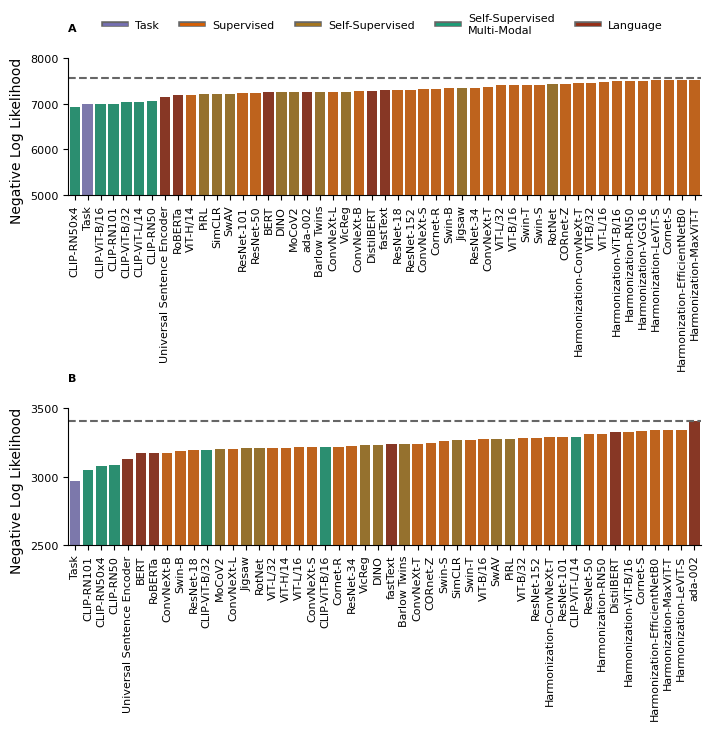

In [ ]:
fig = plt.figure(layout="constrained",figsize=(FIGWIDTH, FIGWIDTH))
spec = fig.add_gridspec(2, )
ax0 = fig.add_subplot(spec[0])
ax0.text(0, 1.2, string.ascii_uppercase[0], transform=ax0.transAxes, weight='bold')

dfs = glob.glob(join(project_root, "data", "learner_behavioural", "category_learning", "*_l1_original.csv"))
dfs = [pd.read_csv(x) for x in dfs]
model_df = pd.concat(dfs)
model_df["nll"] = - np.where(model_df.choice == 1, np.log(model_df.prob), np.log(1-model_df.prob))
chance_level = - model_df.participant.nunique() * CATEGORYTRIALS * np.log(0.5)
model_df = model_df.groupby("features").agg({"nll":"sum"}).reset_index()
model_df = model_df.sort_values(by="nll",ascending=True).reset_index(drop=True)
model_df["color"] = model_df["features"].apply(lambda x: plot_params[x]["colour"])
model_df["features"] = model_df["features"].apply(lambda x: plot_params[x]["name"])

sns.barplot(
    data=model_df,x="features",y="nll",hue="color",dodge=False,ax=ax0,
    hue_order=["task","supervised","self-supervised","self-supervised multimodal","text"]
            )
ax0.legend_.remove()
ax0.axhline(chance_level,ls="--",color=cmap[-1])
# show x-axis ticks in the bars
ax0.xaxis.set_tick_params(rotation=90)
ax0.set_ylabel("Negative Log Likelihood")
ax0.set_xlabel("")
ax0.set_ylim(5000,8000)
ax0.set_yticks([5000,6000,7000,8000])
ax0.yaxis.set_label_coords(-0.07,.4)




ax1 = fig.add_subplot(spec[1])
ax1.text(0, 1.2, string.ascii_uppercase[1], transform=ax1.transAxes, weight='bold')

dfs = glob.glob(join(project_root, "data", "learner_behavioural", "reward_learning", "*_l1_original.csv"))
dfs = [pd.read_csv(x) for x in dfs]
model_df = pd.concat(dfs)
model_df["prob"] = np.where(model_df.prob ==1,.99999,model_df.prob)
model_df["nll"] = - np.where(model_df.choice == 1, np.log(model_df.prob), np.log(1-model_df.prob))
chance_level = - model_df.participant.nunique() * REWARDTRIALS * np.log(0.5)
model_df = model_df.groupby("features").agg({"nll":"sum"}).reset_index()
model_df = model_df.sort_values(by="nll",ascending=True).reset_index(drop=True)
model_df["color"] = model_df["features"].apply(lambda x: plot_params[x]["colour"])
model_df["features"] = model_df["features"].apply(lambda x: plot_params[x]["name"])
reward_model_df = model_df

sns.barplot(
    data=model_df,x="features",y="nll",hue="color",dodge=False,ax=ax1,
    hue_order=["task","supervised","self-supervised","self-supervised multimodal","text"]
            )
ax1.legend_.remove()
ax1.axhline(chance_level,ls="--",color=cmap[-1])
# show x-axis ticks in the bars
ax1.xaxis.set_tick_params(rotation=90)
ax1.set_ylabel("Negative Log Likelihood")
ax1.set_xlabel("")
ax1.set_ylim(2500,3500)
ax1.set_yticks([2500,3000,3500])
ax1.yaxis.set_label_coords(-0.07,.4)

custom_legend_lines = [Line2D([0], [0], color=x, lw=2, path_effects=[pe.Stroke(linewidth=4, foreground=cmap[-1]), pe.Normal()]) for x in cmap[:-1]]
hue_order = ['Task','Supervised','Self-Supervised','Self-Supervised\nMulti-Modal','Language']
fig.legend(custom_legend_lines, hue_order, loc='center',bbox_to_anchor=(0.54, 1),ncol=5,frameon=False)

plt.show()

with mpl.rc_context(latex_context):
    fig.savefig(join(project_root, "figures","sparse_models.pdf"), bbox_inches='tight')


### PCA Models

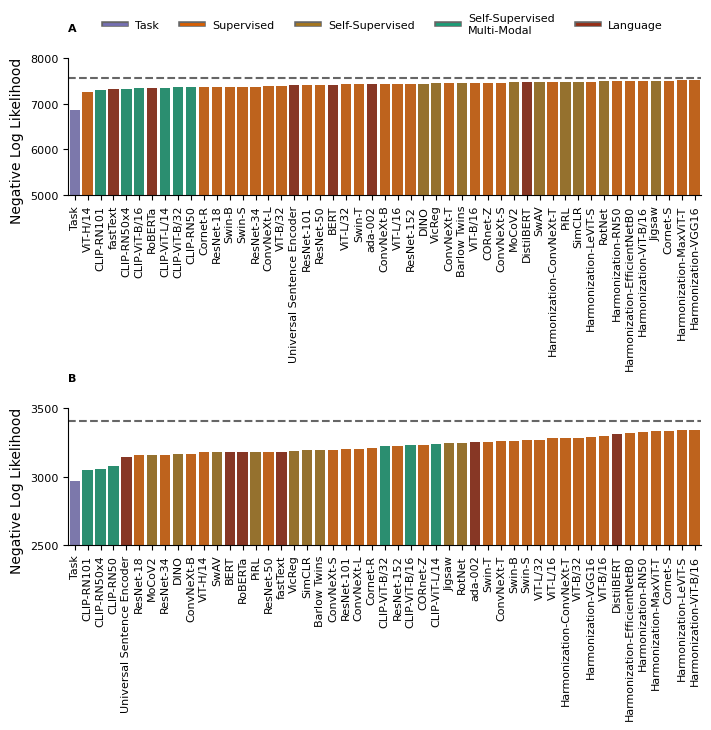

In [ ]:
fig = plt.figure(layout="constrained",figsize=(FIGWIDTH, FIGWIDTH))
spec = fig.add_gridspec(2, )
ax0 = fig.add_subplot(spec[0])
ax0.text(0, 1.2, string.ascii_uppercase[0], transform=ax0.transAxes, weight='bold')

dfs = glob.glob(join(project_root, "data", "learner_behavioural", "category_learning", "*_l2_pca.csv"))
dfs = [pd.read_csv(x) for x in dfs]
model_df = pd.concat(dfs)
model_df["nll"] = - np.where(model_df.choice == 1, np.log(model_df.prob), np.log(1-model_df.prob))
chance_level = - model_df.participant.nunique() * CATEGORYTRIALS * np.log(0.5)
model_df = model_df.groupby("features").agg({"nll":"sum"}).reset_index()
model_df = model_df.sort_values(by="nll",ascending=True).reset_index(drop=True)
model_df["color"] = model_df["features"].apply(lambda x: plot_params[x]["colour"])
model_df["features"] = model_df["features"].apply(lambda x: plot_params[x]["name"])

sns.barplot(
    data=model_df,x="features",y="nll",hue="color",dodge=False,ax=ax0,
    hue_order=["task","supervised","self-supervised","self-supervised multimodal","text"]
            )
ax0.legend_.remove()
ax0.axhline(chance_level,ls="--",color=cmap[-1])
# show x-axis ticks in the bars
ax0.xaxis.set_tick_params(rotation=90)
ax0.set_ylabel("Negative Log Likelihood")
ax0.set_xlabel("")
ax0.set_ylim(5000,8000)
ax0.set_yticks([5000,6000,7000,8000])
ax0.yaxis.set_label_coords(-0.07,.4)




ax1 = fig.add_subplot(spec[1])
ax1.text(0, 1.2, string.ascii_uppercase[1], transform=ax1.transAxes, weight='bold')

dfs = glob.glob(join(project_root, "data", "learner_behavioural", "reward_learning", "*_l2_pca.csv"))
dfs = [pd.read_csv(x) for x in dfs]
model_df = pd.concat(dfs)
model_df["prob"] = np.where(model_df.prob ==1,.99999,model_df.prob)
model_df["nll"] = - np.where(model_df.choice == 1, np.log(model_df.prob), np.log(1-model_df.prob))
chance_level = - model_df.participant.nunique() * REWARDTRIALS * np.log(0.5)
model_df = model_df.groupby("features").agg({"nll":"sum"}).reset_index()
model_df = model_df.sort_values(by="nll",ascending=True).reset_index(drop=True)
model_df["color"] = model_df["features"].apply(lambda x: plot_params[x]["colour"])
model_df["features"] = model_df["features"].apply(lambda x: plot_params[x]["name"])


sns.barplot(
    data=model_df,x="features",y="nll",hue="color",dodge=False,ax=ax1,
    hue_order=["task","supervised","self-supervised","self-supervised multimodal","text"]
            )
ax1.legend_.remove()
ax1.axhline(chance_level,ls="--",color=cmap[-1])
# show x-axis ticks in the bars
ax1.xaxis.set_tick_params(rotation=90)
ax1.set_ylabel("Negative Log Likelihood")
ax1.set_xlabel("")
ax1.set_ylim(2500,3500)
ax1.set_yticks([2500,3000,3500])
ax1.yaxis.set_label_coords(-0.07,.4)

custom_legend_lines = [Line2D([0], [0], color=x, lw=2, path_effects=[pe.Stroke(linewidth=4, foreground=cmap[-1]), pe.Normal()]) for x in cmap[:-1]]
hue_order = ['Task','Supervised','Self-Supervised','Self-Supervised\nMulti-Modal','Language']
fig.legend(custom_legend_lines, hue_order, loc='center',bbox_to_anchor=(0.54, 1),ncol=5,frameon=False)

plt.show()

with mpl.rc_context(latex_context):
    fig.savefig(join(project_root, "figures","pca_models.pdf"), bbox_inches='tight')


### The Effect of Dimensionality

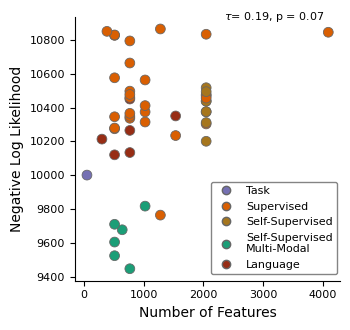

In [ ]:
SINGLECOLWIDTH = 3.4252
fig, ax = plt.subplots(1,1,figsize=(SINGLECOLWIDTH, SINGLECOLWIDTH))

dfs = glob.glob(join(project_root, "data", "learner_behavioural", "category_learning", "*_l2_original.csv"))
dfs = [pd.read_csv(x) for x in dfs]
model_df = pd.concat(dfs)
model_df["nll"] = - np.where(model_df.choice == 1, np.log(model_df.prob), np.log(1-model_df.prob))
chance_level = - model_df.participant.nunique() * CATEGORYTRIALS * np.log(0.5)
model_df = model_df.groupby("features").agg({"nll":"sum"}).reset_index()
model_df = model_df.sort_values(by="nll",ascending=True).reset_index(drop=True)
model_df["color"] = model_df["features"].apply(lambda x: plot_params[x]["colour"])

category_df = model_df

dfs = glob.glob(join(project_root, "data", "learner_behavioural", "reward_learning", "*_l2_original.csv"))
dfs = [pd.read_csv(x) for x in dfs]
model_df = pd.concat(dfs)
model_df["prob"] = np.where(model_df.prob ==1,.99999,model_df.prob)
model_df["nll"] = - np.where(model_df.choice == 1, np.log(model_df.prob), np.log(1-model_df.prob))
chance_level = - model_df.participant.nunique() * REWARDTRIALS * np.log(0.5)
model_df = model_df.groupby("features").agg({"nll":"sum"}).reset_index()
model_df = model_df.sort_values(by="nll",ascending=True).reset_index(drop=True)
model_df["color"] = model_df["features"].apply(lambda x: plot_params[x]["colour"])

reward_model_df = model_df

# merge the two dataframes as new column
model_df = pd.merge(category_df, reward_model_df, on="features", suffixes=("_category", "_reward"))
model_df["nll"] = model_df["nll_category"] + model_df["nll_reward"]
model_df["color"] = model_df["color_category"]

for feat in model_df.features.unique():
    feat_path = join(project_root, "data", "features",f"{feat}.txt")
    # count the number of columns
    with open(feat_path, "r") as f:
        n_cols = len(f.readline().split())
    model_df.loc[model_df.features == feat, "n_features"] = n_cols

model_df["features"] = model_df["features"].apply(lambda x: plot_params[x]["name"])

sns.scatterplot(data=model_df,x="n_features",y="nll",hue="color",ax=ax,palette=cmap[:-2],s=50,legend=False,edgecolor=cmap[-1],
                hue_order=["task","supervised","self-supervised","self-supervised multimodal","text"])
ax.set_xlabel("Number of Features")
ax.set_ylabel("Negative Log Likelihood")


custom_legend_lines = [Line2D([0], [0], color=x, marker="o",markeredgecolor=cmap[-1],linestyle="-", linewidth=0) for x in cmap[:-2]]
hue_order = ['Task','Supervised','Self-Supervised','Self-Supervised\nMulti-Modal','Language']
ax.legend(custom_legend_lines, hue_order, loc='center',bbox_to_anchor=(.75, .2),ncol=1,frameon=True,framealpha=.8,edgecolor=cmap[-1])

r, p = kendalltau(model_df.n_features, model_df.nll)
ax.text(0.75, 1, r"$\tau$" +f"= {r:.2f}, p = {p:.2f}", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)


plt.show()

with mpl.rc_context(latex_context):
    fig.savefig(join(project_root, "figures","representation_size.pdf"), bbox_inches='tight')

#| hide
### Model Descriptions

In [ ]:
#| hide
# initialise empty dataframe with features written in the cell above
supp_df = pd.DataFrame(
    {
    ("","Name"): [],
    ("","Type"): [],
    ("","Parameters (Million)"): [],
    ("Category Learning NLL", "Main Text"): [],
    ("Category Learning NLL", "Sparse"): [],
    ("Category Learning NLL", "PCA"): [],
    ("Reward Learning NLL", "Main Text"): [],
    ("Reward Learning NLL", "Sparse"): [],
    ("Reward Learning NLL", "PCA"): [],
    }
)

supp_df

In [ ]:
#| hide
description_json = {}

for model in plot_params.keys():
    description_json[model] = "This is a description. This is a description. This is a description. This is a description. This is a description. This is a description."

In [ ]:
#| hide
harmonization_variants = {
    "ViT_B16": load_ViT_B16,
    "ResNet50": load_ResNet50,
    "VGG16": load_VGG16,
    "EfficientNetB0": load_EfficientNetB0,
    "tiny_ConvNeXT": load_tiny_ConvNeXT,
    "tiny_MaxViT": load_tiny_MaxViT,
    "LeViT_small": load_LeViT_small,
}


language_size = {
    "task": "0.19", # initialised
    "fasttext": "NA",
    "distilbert": "66.36",
    "bert": "109.48",
    "roberta": "124.65",
    "universal_sentence_encoder": "NA",
    "ada-002": "350"
}


with open(join(project_root, "data", "model_configs.json")) as f:
    model_configs = json.load(f)

In [ ]:
#| hide
for model in tqdm(model_configs.keys()):
    name = plot_params[model.replace("/","_")]["name"]
    kind = plot_params[model.replace("/","_")]["colour"]

    if model.startswith("Harmonization"):
        extractor = get_extractor_from_model(
            model=harmonization_variants[model.split("Harmonization_")[-1]](), 
            device="cpu",
            backend="tf",
            )
        
        size = extractor.model.count_params()
    
    elif model in ["task","fasttext","distilbert","bert","roberta","universal_sentence_encoder","ada-002"]:
        size = language_size[model]
    
    else:
        extractor = get_extractor(
            model_name="clip" if "clip" in model else model,
            source = model_configs[model]["source"],
            device="cpu",
            pretrained=True,
            model_parameters={"variant": model.split("clip_")[-1]} if model.startswith("clip") else None

        )
        size = sum(p.numel() for p in extractor.model.parameters())

    try:
        size= str(round(size/1000000,2))
    except:
        pass

    
    category_main_df = pd.read_csv(
        join(
        project_root,"data","learner_behavioural","category_learning",f"{model.replace('/','_')}_l2_original.csv"
        )
    )
    category_main_df["prob"] = np.where(category_main_df.prob ==1,.99999,category_main_df.prob)
    category_main_df["nll"] = - np.where(category_main_df.choice == 1, np.log(category_main_df.prob), np.log(1-category_main_df.prob))
    category_main_nll = category_main_df.nll.sum().round(2)

    category_sparse_df = pd.read_csv(
        join(
        project_root,"data","learner_behavioural","category_learning",f"{model.replace('/','_')}_l1_original.csv"
        )
    )
    category_sparse_df["prob"] = np.where(category_sparse_df.prob ==1,.99999,category_sparse_df.prob)
    category_sparse_df["nll"] = - np.where(category_sparse_df.choice == 1, np.log(category_sparse_df.prob), np.log(1-category_sparse_df.prob))
    category_sparse_nll = category_sparse_df.nll.sum().round(2)

    category_pca_df = pd.read_csv(
        join(
        project_root,"data","learner_behavioural","category_learning",f"{model.replace('/','_')}_l2_pca.csv"
        )
    )
    category_pca_df["prob"] = np.where(category_pca_df.prob ==1,.99999,category_pca_df.prob)
    category_pca_df["nll"] = - np.where(category_pca_df.choice == 1, np.log(category_pca_df.prob), np.log(1-category_pca_df.prob))
    category_pca_nll = category_pca_df.nll.sum().round(2)


    reward_main_df = pd.read_csv(
        join(
        project_root,"data","learner_behavioural","reward_learning",f"{model.replace('/','_')}_l2_original.csv"
        )
    )
    reward_main_df["prob"] = np.where(reward_main_df.prob ==1,.99999,reward_main_df.prob)
    reward_main_df["nll"] = - np.where(reward_main_df.choice == 1, np.log(reward_main_df.prob), np.log(1-reward_main_df.prob))
    reward_main_nll = reward_main_df.nll.sum().round(2)

    try:
        reward_sparse_df = pd.read_csv(
            join(
            project_root,"data","learner_behavioural","reward_learning",f"{model.replace('/','_')}_l1_original.csv"
            )
        )
        reward_sparse_df["prob"] = np.where(reward_sparse_df.prob ==1,.99999,reward_sparse_df.prob)
        reward_sparse_df["nll"] = - np.where(reward_sparse_df.choice == 1, np.log(reward_sparse_df.prob), np.log(1-reward_sparse_df.prob))
        reward_sparse_nll = reward_sparse_df.nll.sum().round(2)
    except:
        reward_sparse_nll = "NA"

    reward_pca_df = pd.read_csv(
        join(
        project_root,"data","learner_behavioural","reward_learning",f"{model.replace('/','_')}_l2_pca.csv"
        )
    )
    reward_pca_df["prob"] = np.where(reward_pca_df.prob ==1,.99999,reward_pca_df.prob)
    reward_pca_df["nll"] = - np.where(reward_pca_df.choice == 1, np.log(reward_pca_df.prob), np.log(1-reward_pca_df.prob))
    reward_pca_nll = reward_pca_df.nll.sum().round(2)



    supp_df.loc[len(supp_df.index)] = [name,kind,size,
                                       category_main_nll,category_sparse_nll,category_pca_nll,
                                       reward_main_nll,reward_sparse_nll,reward_pca_nll]
    supp_df = supp_df.reset_index(drop=True)


In [ ]:
#| hide
supp_df[("",'Type')] = supp_df[("",'Type')].replace('self-supervised multimodal','Self-Supervised Multi-Modal')
supp_df[("",'Type')] = supp_df[("",'Type')].replace('self-supervised','Self-Supervised')
supp_df[("",'Type')] = supp_df[("",'Type')].replace('text','Language')
supp_df[("",'Type')] = supp_df[("",'Type')].replace('supervised','Supervised')
supp_df[("",'Type')] = supp_df[("",'Type')].replace('task','Task')

In [ ]:
#| hide
sorted_indices = (supp_df[("Category Learning NLL", "Main Text")] + supp_df[("Reward Learning NLL", "Main Text")]).sort_values().index

supp_df_print = supp_df.loc[sorted_indices,:]

In [ ]:
#| hide
with pd.option_context("max_colwidth",1000000):
    print(supp_df_print.reset_index(drop=True).to_latex(index=False))